## Results metrics

A threshold "T" is used to classify a test case to be either a correct (true or positive) case or false (negative) case. If the case is below a threshold "T" then it is classified false (negative) and if it is above threshold "T" it is classified true (positive).

**FPIR**: is the false positive identification rate. It is the ratio of the test cases that are classified as true cases although they are false cases. It is type I error. 
FPIR= Number of test cases classified above threshold "T" (true) / Number of all test cases

**FNIR**: is the false negative identification rate. It is  the ratio of the test cases that are classified as false cases although they are true cases. It is type II error.
FNIR= Number of test cases classified below threshold "T" (false) / Number of all test cases

In [2]:
# Load libraries
import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import seaborn as sns
sns.set(style="white") 
%matplotlib inline

### AdaFace results

In [3]:
# File path
file_path = '/Users/gabriellakierulff/Desktop/HCAI/speciale/Master_Thesis/master_thesis/saved_predictions/image_data_similarity_scores_ylfw.pt'

# Load the file
data = torch.load(file_path)
data.keys()

dict_keys(['image_id', 'feature_vectors', 'similarity_scores'])

**False Negatives**
FNIR represent the proportion of feature vectors that belong to a certain class but are incorrectly classified as not belonging to that class.

In [71]:
# Analyze similarity scores in terms of threshold...

# For the first 10 similarity scores - what is the distribution of the scores?
sim_scores = data["similarity_scores"][:10,:10]



In [106]:
plot_sims = sim_scores.detach().flatten().numpy()
len(plot_sims)

100

In [109]:
# Example array
plot_sims = np.array([0.9999999, 0.99994, 0.999, 0.99])

# Tolerance level
tolerance = 1e-4  # Adjust tolerance level as needed

# Filter out values close to 1 using np.isclose()
plot_sims_filtered = plot_sims[~np.isclose(plot_sims, 1.0, atol=tolerance)]
plot_sims_filtered

array([0.999, 0.99 ])

In [104]:
all_close_to_1

False

In [112]:
sim_scores

tensor([[ 1.0000,  0.5107,  0.3419,  0.0360, -0.0292,  0.1497,  0.1862,  0.1650,
          0.0163,  0.3325],
        [ 0.5107,  1.0000,  0.3804,  0.1542, -0.0509,  0.2338,  0.1970,  0.2137,
          0.0543,  0.2434],
        [ 0.3419,  0.3804,  1.0000,  0.2527,  0.1244,  0.2784,  0.3202,  0.2186,
          0.1324,  0.1956],
        [ 0.0360,  0.1542,  0.2527,  1.0000,  0.2807,  0.1589,  0.2542,  0.3198,
          0.2264, -0.0018],
        [-0.0292, -0.0509,  0.1244,  0.2807,  1.0000,  0.3786,  0.3950,  0.2787,
          0.2726,  0.1439],
        [ 0.1497,  0.2338,  0.2784,  0.1589,  0.3786,  1.0000,  0.4893,  0.3422,
          0.2151,  0.2240],
        [ 0.1862,  0.1970,  0.3202,  0.2542,  0.3950,  0.4893,  1.0000,  0.3547,
          0.2331,  0.2444],
        [ 0.1650,  0.2137,  0.2186,  0.3198,  0.2787,  0.3422,  0.3547,  1.0000,
          0.3798,  0.2078],
        [ 0.0163,  0.0543,  0.1324,  0.2264,  0.2726,  0.2151,  0.2331,  0.3798,
          1.0000,  0.0533],
        [ 0.3325,  

In [120]:
len(sim_scores[sim_scores < 0.9999])

90

In [138]:
len(sim_scores)

10

In [139]:
plot_sims = sim_scores[sim_scores < 0.999].detach().flatten().numpy()
len(plot_sims)

90

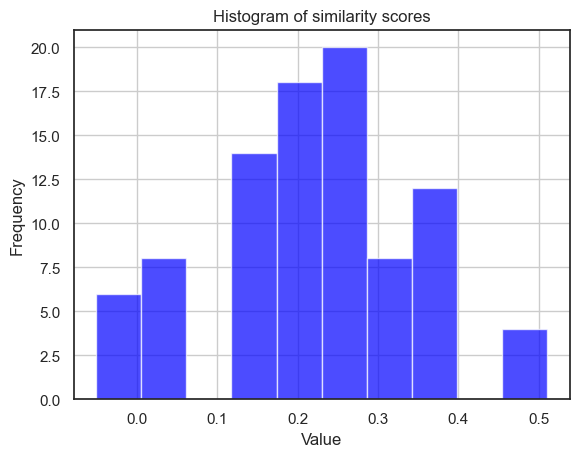

Average similarity score:  0.2246168

Top 10% similarity score:  0.48925721645355225

Top 10 highest similarity score: [0.37976742 0.37976742 0.3803856  0.3803856  0.39495435 0.39495435
 0.48925722 0.48925722 0.5106703  0.5106703 ]

Max sim scores:  0.5106703


In [132]:
# Convert tensor to NumPy array
plot_sims = sim_scores[sim_scores < 0.999].detach().flatten().numpy() # filter out values equal to 1 #OBS check more scietific way
# Plot histogram
plt.hist(plot_sims, bins=len(sim_scores), color='blue', alpha=0.7)
plt.title('Histogram of similarity scores')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print("Average similarity score: ", np.mean(plot_sims))
print("\nTop 10% similarity score: ", np.percentile(plot_sims, 97.5))
print("\nTop 10 highest similarity score:", np.sort(plot_sims)[-10:])
print("\nMax sim scores: ", np.max(plot_sims))

In [146]:
## Data


sim_scores = data["similarity_scores"][:10,:10]
# E.g. classify all identities as positive if threshold is higher than 90% of all similarity scores
sims_excluding_probe = sim_scores[sim_scores < 0.99] # OBs check if more scientific way
# Check that length of similarity scores are equal to len(sim_scores.flatten)- len(sim_scores)
print("Length of similarity scores without probe: ", len(sims_excluding_probe), "Equal to: ", len(sim_scores.flatten()) - len(sim_scores), 
      "is",len(sims_excluding_probe) == (len(sim_scores.flatten()) - len(sim_scores)))


Length of similarity scores without probe:  90 Equal to:  90 is True


In [167]:
# False Positives = Number of instances belonging to the negative class but are classified as the positive class
# True Negatives = Number of instances belonging to the negative class that are correctly classsified as the negative class
# True positives: N instances belonging to the positive class that were also correctly classified as the positive class
# False negatives: N instances belonging to the positive class that were incorrectly classified to the negative class


def remove_probeid_in_classification(arr, value):
    for i, v in enumerate(arr):
        if v == value:
            return np.delete(arr, i)
    return arr  # Value not found in the array, return the original array


## Threshold set based on studying the similarity scores
thold = np.percentile(plot_sims, 90)
im_ids = np.array(data["image_id"][:10])

tps = []
fps = []
tns = []
fns = []

for i in range(0,len(sim_scores)):
    probe = im_ids[i]
    print(probe)
    
    # for probe i
    # Positive classification list
    classified_positive_list = sim_scores[i] >= thold
    classified_positive_idx = list(np.where(classified_positive_list)[0])
        
    # get the classified identities - positive
    face_idx_pos_class = im_ids[classified_positive_idx]
    print("cor ids",face_idx_pos_class)
    
    # remove first instance of probe id in classification list
    face_idx_pos_class_filtered = remove_probeid_in_classification(face_idx_pos_class, probe)
    print("filt, ids",face_idx_pos_class_filtered)

    
    # get TP
    tp = np.sum(face_idx_pos_class_filtered == probe)
    tps.append(tp)
    
    # get FP (classified as correct but not equal to probe)
    fp = len(face_idx_pos_class_filtered) - tp
    fps.append(fp)
    
    # Negative classification list
    classified_negative_list = sim_scores[i] < thold
    classified_negative_idx = list(np.where(classified_negative_list)[0])
    
    # get the classified identities - negative
    face_idx_neg_class = im_ids[classified_negative_idx]
    face_idx_neg_class_filtered = remove_probeid_in_classification(face_idx_neg_class, probe)


    # get TN (classified as false and not equal to probe)
    tn = np.sum(face_idx_neg_class_filtered != probe)
    tns.append(tn)
    
    # get FN (classified as false, but is actually equal to probe)
    fn = len(face_idx_neg_class_filtered) - tn
    fns.append(fn)


0
cor ids [0 0]
filt, ids [0]
0
cor ids [0 0 1]
filt, ids [0 1]
1
cor ids [0 1]
filt, ids [0]
1
cor ids [1]
filt, ids []
2
cor ids [2 2]
filt, ids [2]
2
cor ids [2 2]
filt, ids [2]
2
cor ids [2 2 2]
filt, ids [2 2]
2
cor ids [2 2]
filt, ids [2]
2
cor ids [2 2]
filt, ids [2]
3
cor ids [3]
filt, ids []


##### FNIR

In [170]:
# FNIR = FN / (TP + FN)
fnir = np.sum(fns) / (np.sum(tps) + np.sum(fns))
print("FNIR result: ", fnir)

FNIR result:  0.5294117647058824


##### FPIR

In [171]:
# FPIR = FP / (FP + TN)
fpir = np.sum(fps) / (np.sum(fps) + np.sum(tns))
print("FPIR result: ", fpir)

FPIR result:  0.030303030303030304


#### GARBE

### MagFace Results

In [ ]:
# File path
# YLFW
with open('../data/raw/YLFW_bench/feat.list', 'r') as f:
    lines = f.readlines()
# Load the file
data = torch.load(file_path)
data.keys()

In [ ]:
img_2_feats = {}
img_2_mag = {}
for line in lines:
    parts = line.strip().split(' ')
    imgname = parts[0]
    imgname = "/"+"/".join(imgname.split("/")[4:])
    feats = [float(e) for e in parts[1:]]
    mag = np.linalg.norm(feats)
    img_2_feats[imgname] = feats/mag
    img_2_mag[imgname] = mag #magnitude of the feature vector

In [ ]:
imgnames = list(img_2_mag.keys())
mags = [img_2_mag[imgname] for imgname in imgnames]
sort_idx = np.argsort(mags) #sorts the magnitude/quality of the images

In [ ]:
#feats = np.array([img_2_feats[imgnames[ele]] for ele in sort_idx[:10]])
feats = np.array([img_2_feats[imgnames[ele]] for ele in range(10)]) #unsorted image quality
ids = np.array([imgnames[ele] for ele in range(10)])

sim_mat = np.dot(feats, feats.T)